 <h1 align="center">Generating a Probability Distribution of Attack Relations From Annotated Data</h1> 

In this workbook we look at the process of generating a probability distribution of attack relationships between a set of arguments types observed across a set of product reviews. 

Let's suppose we're glossing over a set of reviews for a drug we are interested in. A review constitutes a textual review provided by the user and a rating number indicating the user's satisfaction with the drug. For example:

<blockquote>
<b>REVIEW: </b><i>"The drug made me sick. It caused headaches, vomitting and a serious loss of appetite. I was miserable taking it."</i>
<br>
<b>RATING: </b>3
<br>
<br>
<b>REVIEW: </b><i>"The drug was fantastic. It helped me regain control of my life. I suffered no side effects. I am optimistic with the remainder of my course with the drug!"</i>
<br>
<b>RATING: </b>9
</blockquote>

What we begin to realise over the process of reading a number of such reviews is that reviews tend to focus their comments on a small number of topics. Taking our example, this may include things like <i>experiencing side effects</i>, <i>not having any side effects</i>, <i>having a generally positive experience with the drug</i> etc. 

We identify 6 types of common claims made by the reviewers:
<ol>
  <li>Positive Experience with the drug</li>
  <li>Negative Experience with the drug</li>
  <li>Side Effects Experienced</li>
  <li>No Side Effects Experienced</li>
  <li>Side Effects Experienced yet they are bearable</li>
  <li>Side Effects are unbearable</li>  
</ol> 

We asked an annotator to annotate 100 such reviews, and identify each sentence as being one or more the the argument types listed above.

<h1>Function for Calculating the Grounded Extension of a Graph</h1>

If we consider a Dung graph, the grounded extension is the subset of arguments whose set is defended from other attacks.

Below we outline an algorithm for calculating the grounded extension given any argument graph

In [26]:
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

def getInOutArgs(argMtx):
    sumArgs = argMtx.sum(axis=0)
    
    inArgs = np.argwhere(sumArgs == 0)
    inArgs = (inArgs.tolist())
    inArgs = [i[0] for i in inArgs]
    
    attacked = argMtx[inArgs, :]
    
    outArgs = (np.unique(np.where(attacked>0)[1])).tolist()
    
    return inArgs, outArgs

def calculateGroundedExtension(argMtx):
    argTypes = np.array(range(0, argMtx.shape[0]))
    ext = []
    terminate = False

    while not terminate:
        inArgs, outArgs = getInOutArgs(argMtx)

        if len(inArgs) > 0:
            ext.extend(list(argTypes[inArgs]))
            argsDelete = inArgs + outArgs
            argMtx = np.delete(argMtx, argsDelete, axis = 0)
            argMtx = np.delete(argMtx, argsDelete, axis = 1)
            argTypes = np.delete(argTypes, argsDelete)

        else:
            break

        sums = np.sum(argMtx.sum(axis=0))
        
        # If we find that the resulting graph (having deleted current in and out args) is got no more attacks in it then add 
        # whatever is leftover to the extension
        if sums == 0:
            ext.extend(list(argTypes))
            terminate = True
        
    return ext

<h1>Function for Generating the Probability Distribution given a Set of Reviews and Ratings</h1>

In [46]:
def generatePermutations(posArgs, negArgs):

    from itertools import product, chain

    posPerms = np.array(list(itertools.product([0,1], repeat=len(posArgs)*len(negArgs))))
    negPerms = np.array(list(itertools.product([0,1], repeat=len(negArgs)*len(posArgs))))

    allPermsList = [list(chain(*i)) for i in product(posPerms, negPerms)]

    posIdxs = []
    negIdxs = []

    currPos = 0
    for x in range(len(posArgs)):
        start = currPos + len(posArgs)
        posIdxs.extend(range(start, start + len(negArgs)))
        currPos += (len(posArgs) + len(negArgs))


    currNeg = len(posArgs)*(len(posArgs) + len(negArgs))
    for x in range(len(negArgs)):
        start = currNeg
        negIdxs.extend(range(start, start + len(posArgs)))
        currNeg += (len(posArgs) + len(negArgs))

    allPerms = np.zeros(shape=(len(allPermsList), (len(posArgs)+len(negArgs))**2))
    allPermsList = np.array(allPermsList)

    allPerms[:,posIdxs] = allPermsList[:,0:(len(posArgs)*len(negArgs))]
    allPerms[:,negIdxs] = allPermsList[:,(len(posArgs)*len(negArgs)):]

    return allPerms

def calculateProbabilityDistribution(posArgs, negArgs, rating):
    
    nargs = len(posArgs + negArgs)
    allPermutations = generatePermutations(posArgs, negArgs)
    
    # Determine the Polarity of the Post
    if rating < 5:
        groundedExtension = negArgs
    elif rating > 6:
        groundedExtension = posArgs
    else:
        groundedExtension = []
    

    # Iterate over the set of graphs that are possible (excluding circular attacks and same polarity attacks) to see which one's 
    # have a grounded extension matching the polarti
    acceptedGraphs = []
    for graph in allPermutations:
        attMtx = np.vstack( np.array_split(np.array(graph), nargs))
        ext = calculateGroundedExtension(attMtx)
        if set(groundedExtension) == set(ext): 
            acceptedGraphs.append(graph.tolist()) 
        
    # Aggregate then normalise the complete set of Attacks
    acceptedGraphs = np.array(acceptedGraphs)
    sumOfAttacks = (acceptedGraphs).sum(axis=0)
    normalisedAttcks = sumOfAttacks / acceptedGraphs.shape[0]
    
    return normalisedAttcks

<h1>Using Annotated Data to Generate Probability Distribution of Attacks</h1>

Next we pass our 100 annotated set of posts through our algorithm

In [28]:
import json

highestRating = 10
positiveArgTypes = [0,3,5]
negativeArgTypes = [1,2,4]
noArgsTypes = len(positiveArgTypes) + len(negativeArgTypes)


# Collect the annotation data into a numpy array
annotatedPosts = []
numericalsRatings = []

with open('allAnnotationsChutesRun1.json') as data_file:
    with open('ForumPosts.json') as ratings_file:
        data = json.load(data_file)
        

        ratings = json.load(ratings_file)
        
        for idx, d in enumerate(data):
            # We get 'Nones' sometimes when things left completeley blank. Replace with 0's so as not to interfere
            # with our sums whilst letting us keep track of noOfSentences per post
            d = [[0, 0, 0, 0, 0, 0, 0] if v is None else v for v in d] 

            d = np.array(d)
            sums = d.sum(axis=0)
            sums = np.argwhere(sums > 0)
            sums = sums[sums !=6]
            annotatedPosts.append(sums.tolist())
            
            numericalsRatings.append(ratings[idx]['Rating'])


annotatedPosts = np.array(annotatedPosts)
numericalsRatings = np.array(numericalsRatings)


# Begin generating the distributions per post 
globalGraph = np.zeros(noArgsTypes*noArgsTypes)

for idx, review in enumerate(annotatedPosts):
    
    posArgs = list(set(positiveArgTypes).intersection(review))
    negArgs = list(set(negativeArgTypes).intersection(review))
    posArgsIdx = list(range(0,len(posArgs)))
    negArgsIdx = list(range(len(posArgs), len(posArgs)+len(negArgs)))

    nmlDstb = calculateProbabilityDistribution(posArgsIdx, negArgsIdx, numericalsRatings[idx])
    globalContribution = np.zeros(noArgsTypes*noArgsTypes)
    
    noOfArgTypesFound = len(list(posArgs+negArgs))
    
    allAttacks = list(itertools.product(list(posArgs+negArgs), repeat=2))
    allAttacksIdx = []
    for attack in allAttacks:
        ptn = ((attack[0]+1)*noArgsTypes)- ((noArgsTypes+1) - attack[1])+1
        allAttacksIdx.append(ptn)
    

    globalContribution[allAttacksIdx] = nmlDstb
    
    if(np.isnan(globalContribution).any()):
        continue
    
    globalGraph = np.add(globalGraph, globalContribution)
    #print(globalGraph)

globalGraphMtxForm = np.vstack( np.array_split(np.array(globalGraph), noArgsTypes))

        

<h1>Visualising the Probability Distribution Using a Dung Graph</h1>

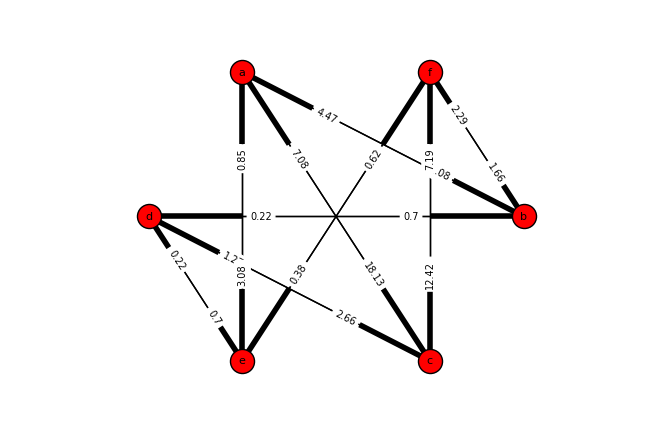

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import string


G = nx.DiGraph()
letters = list(string.ascii_lowercase) # Will fail if we have more arguments than the number of letters in the alphabet
nodesNames = letters[0:globalGraphMtxForm.shape[0]] 

for (r,c), weight in np.ndenumerate(globalGraphMtxForm):
    if weight == 0:
        continue
    G.add_edge(nodesNames[r], nodesNames[c], length = round(weight,2))
 
#pos = nx.spring_layout(G,scale=5)
pos = nx.circular_layout(G, scale=5)
nx.draw(G, pos)
edge_labels=dict([((u,v,),d['length'])
             for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)

labels = {}
for node in nodesNames:
    labels[node] = node

nx.draw_networkx_labels(G,pos,labels,font_size=8)


plt.show()

<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Node Label</th>
    <th>Argument Type</th>
  </tr>
  <tr>
    <td>a</td>
    <td>Positive Experience</td>
  </tr>
  <tr>
    <td>b</td>
    <td>Negative Experience</td>
  </tr>
  <tr>
    <td>c</td>
    <td>Side Effects Present</td>
  </tr>
  <tr>
    <td>d</td>
    <td>No Side Effects</td>
  </tr>
  <tr>
    <td>e</td>
    <td>Side Effects Painful</td>
  </tr>
  <tr>
    <td>f</td>
    <td>Bearable Side Effects</td>
  </tr>
</table>

</body>
</html>


<h1>Partitioning the Annotated Data</h1>

In the next step we investigate the following questions:

 <ol>
  <li>Testing the argument graph generated above on the dataset</li>
  <li>Seeing how the argument graph above correlates to the ratings of the posts</li>
</ol> 

In [36]:
trainingData = annotatedPosts[0:50]
trainingRatings = numericalsRatings[0:50]
testData = annotatedPosts[51:-1]
testRating = numericalsRatings[51:-1]

In [37]:
numericalsRatings = np.array(trainingRatings)


# Begin generating the distributions per post 
globalGraph = np.zeros(noArgsTypes*noArgsTypes)

for idx, review in enumerate(trainingData):
    
    posArgs = list(set(positiveArgTypes).intersection(review))
    negArgs = list(set(negativeArgTypes).intersection(review))
    posArgsIdx = list(range(0,len(posArgs)))
    negArgsIdx = list(range(len(posArgs), len(posArgs)+len(negArgs)))

    nmlDstb = calculateProbabilityDistribution(posArgsIdx, negArgsIdx, numericalsRatings[idx])
    globalContribution = np.zeros(noArgsTypes*noArgsTypes)
    
    noOfArgTypesFound = len(list(posArgs+negArgs))
    
    allAttacks = list(itertools.product(list(posArgs+negArgs), repeat=2))
    allAttacksIdx = []
    for attack in allAttacks:
        ptn = ((attack[0]+1)*noArgsTypes)- ((noArgsTypes+1) - attack[1])+1
        allAttacksIdx.append(ptn)
    

    globalContribution[allAttacksIdx] = nmlDstb
    
    if(np.isnan(globalContribution).any()):
        continue
    
    globalGraph = np.add(globalGraph, globalContribution)
    #print(globalGraph)

globalGraphMtxForm = np.vstack( np.array_split(np.array(globalGraph), noArgsTypes))

        

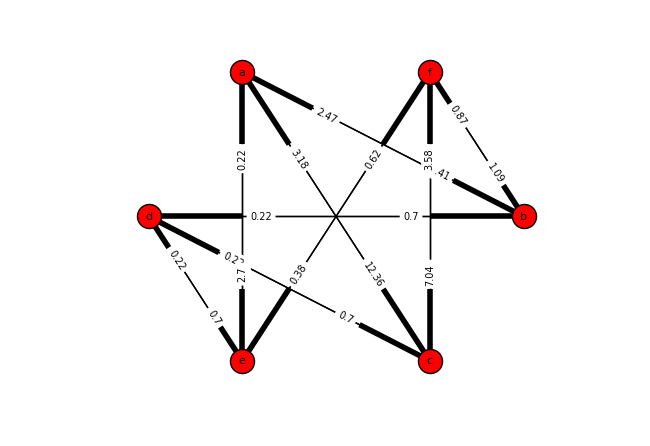

In [38]:
G = nx.DiGraph()
letters = list(string.ascii_lowercase) # Will fail if we have more arguments than the number of letters in the alphabet
nodesNames = letters[0:globalGraphMtxForm.shape[0]] 

for (r,c), weight in np.ndenumerate(globalGraphMtxForm):
    if weight == 0:
        continue
    G.add_edge(nodesNames[r], nodesNames[c], length = round(weight,2))
 
#pos = nx.spring_layout(G,scale=5)
pos = nx.circular_layout(G, scale=5)
nx.draw(G, pos)
edge_labels=dict([((u,v,),d['length'])
             for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)

labels = {}
for node in nodesNames:
    labels[node] = node

nx.draw_networkx_labels(G,pos,labels,font_size=8)


plt.show()

<h2>Applying our test data</h2>

In [60]:
analagousRatingDistribution = []
positiveArgTypes = [0,3,5]
negativeArgTypes = [1,2,4]

for idx, review in enumerate(testData):
    posArgs = list(set(positiveArgTypes).intersection(review))
    negArgs = list(set(negativeArgTypes).intersection(review))
    
    allArgs = sorted(posArgs + negArgs)
    print('allargs', allArgs)
    argWeights = globalGraphMtxForm[allArgs]
    argWeights = argWeights[:,allArgs]
    
    print('weight',argWeights)
    #posArgsIdx = list(range(0,len(posArgs)))
    #negArgsIdx = list(range(len(posArgs), len(posArgs)+len(negArgs)))
    # allPermutations = generatePermutations(posArgsIdx, negArgsIdx)
    
    
    
    

allargs [1, 2]
weight [[ 0.  0.]
 [ 0.  0.]]
allargs [0, 2, 5]
weight [[  0.          12.3637339    0.        ]
 [  3.1824034    0.           3.57980977]
 [  0.           7.0380764    0.        ]]
allargs [1]
weight [[ 0.]]
allargs [1, 2, 4]
weight [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
allargs [0, 1, 2, 4]
weight [[  0.           6.41135295  12.3637339    2.70403587]
 [  2.46811769   0.           0.           0.        ]
 [  3.1824034    0.           0.           0.        ]
 [  0.22421525   0.           0.           0.        ]]
allargs [0, 1, 2]
weight [[  0.           6.41135295  12.3637339 ]
 [  2.46811769   0.           0.        ]
 [  3.1824034    0.           0.        ]]
allargs [1, 2, 4]
weight [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
allargs [1]
weight [[ 0.]]
allargs [0, 2, 3, 5]
weight [[  0.          12.3637339    0.           0.        ]
 [  3.1824034    0.           0.22421525   3.57980977]
 [  0.           0.70403587   0.           0.        ]
 [  0.       

In [45]:
print(globalGraphMtxForm)

[[  0.           6.41135295  12.3637339    0.           2.70403587   0.        ]
 [  2.46811769   0.           0.           0.22421525   0.           0.86552406]
 [  3.1824034    0.           0.           0.22421525   0.           3.57980977]
 [  0.           0.70403587   0.70403587   0.           0.70403587   0.        ]
 [  0.22421525   0.           0.           0.22421525   0.           0.62162162]
 [  0.           1.08569545   7.0380764    0.           0.37837838   0.        ]]


In [62]:
print(np.triu(globalGraphMtxForm))

[[  0.           6.41135295  12.3637339    0.           2.70403587   0.        ]
 [  0.           0.           0.           0.22421525   0.           0.86552406]
 [  0.           0.           0.           0.22421525   0.           3.57980977]
 [  0.           0.           0.           0.           0.70403587   0.        ]
 [  0.           0.           0.           0.           0.           0.62162162]
 [  0.           0.           0.           0.           0.           0.        ]]


In [64]:
print(np.tril(globalGraphMtxForm))

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 2.46811769  0.          0.          0.          0.          0.        ]
 [ 3.1824034   0.          0.          0.          0.          0.        ]
 [ 0.          0.70403587  0.70403587  0.          0.          0.        ]
 [ 0.22421525  0.          0.          0.22421525  0.          0.        ]
 [ 0.          1.08569545  7.0380764   0.          0.37837838  0.        ]]
